In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import pprint

from sklearn.linear_model import LogisticRegression as SKLogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
from sklearn.impute import SimpleImputer
from scipy.stats import chi2_contingency
from category_encoders import TargetEncoder

pp = pprint.PrettyPrinter(indent=4, depth=4)

# Salary Classification


## 3.1 Exploratory Data Analysis - EDA

In [117]:
full_relative_path = "tema2_SalaryPrediction/SalaryPrediction_full.csv"
train_relative_path = "tema2_SalaryPrediction/SalaryPrediction_train.csv"
test_relative_path = "tema2_SalaryPrediction/SalaryPrediction_test.csv"

salary_df = pd.read_csv(full_relative_path)
salary_train_df = pd.read_csv(train_relative_path)
salary_test_df = pd.read_csv(test_relative_path)

# Print the first 10 rows to check if the data has been loaded and what features are present
salary_df.head(10)

,fnl,hpw,relation,gain,country,job,edu_int,years,loss,work_type,partner,edu,gender,race,prod,gtype,money
0,264627,40.0,NotM,0,United-States,Adm-clerical,10,38,0,Priv,D,SC,NaN,White,77,DC,<=50K
1,151369,40.0,NotF,0,United-States,Craft-repair,9,62,0,LGov,NM,HSG,M,White,87,AC,<=50K
2,188615,60.0,H,0,United-States,Sales,13,42,0,SelfInc,MCS,B,M,White,77,AC,>50K
3,151089,55.0,H,0,United-States,Exec-managerial,10,41,2415,SelfInc,MCS,SC,M,White,107,AC,>50K
4,177625,40.0,NotF,0,United-States,Machine-op-inspct,9,25,0,Priv,NM,HSG,M,White,57,AC,<=50K
5,444089,40.0,NotF,0,United-States,Sales,7,56,0,Priv,D,11,F,White,62,DC,<=50K
6,101320,75.0,NotF,0,United-States,Exec-managerial,14,49,0,Priv,D,M,F,White,62,DC,<=50K
7,35411,40.0,NotF,0,United-States,Machine-op-inspct,9,59,0,Priv,W,HSG,F,White,82,DC,<=50K
8,93235,25.0,OwnC,0,United-States,Other-service,8,17,1721,Priv,NM,12,F,White,67,DC,<=50K
9,232855,37.0,NotM,0,United-States,Other-service,10,34,0,Priv,S,SC,F,Black,52,DC,<=50K


In [118]:
# Check the shape of the dataframe
print(salary_df.shape)

(9999, 17)


In [119]:
# Data type for each column
for col in salary_df.columns:
    print(col, "is of type", type(salary_df[col][0]))

fnl is of type <class 'numpy.int64'>
hpw is of type <class 'numpy.float64'>
relation is of type <class 'str'>
gain is of type <class 'numpy.int64'>
country is of type <class 'str'>
job is of type <class 'str'>
edu_int is of type <class 'numpy.int64'>
years is of type <class 'numpy.int64'>
loss is of type <class 'numpy.int64'>
work_type is of type <class 'str'>
partner is of type <class 'str'>
edu is of type <class 'str'>
gender is of type <class 'float'>
race is of type <class 'str'>
prod is of type <class 'numpy.int64'>
gtype is of type <class 'str'>
money is of type <class 'str'>


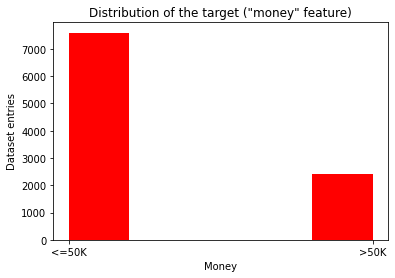

'We may observe that there is a lot more data for <= 50k salaries'

In [120]:
# Analyzing the target feature
target = salary_df['money']

plt.hist(target, color = 'red', bins = 5)
plt.xlabel('Money')
plt.ylabel('Dataset entries')
plt.title('Distribution of the target ("money" feature)')
plt.show()

"""We may observe that there is a lot more data for <= 50k salaries"""

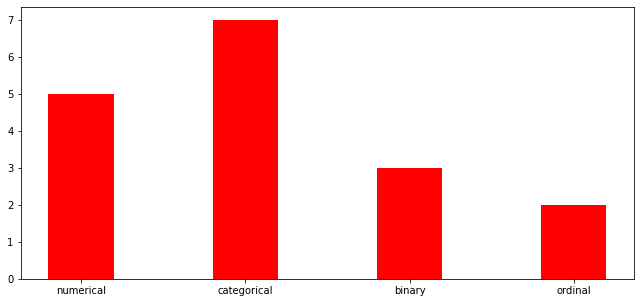

{   'binary': {'attributes': ['gender', 'gtype', 'money'], 'size': 3},
    'categorical': {   'attributes': [   'relation',
                                         'country',
                                         'job',
                                         'work_type',
                                         'partner',
                                         'edu',
                                         'race'],
                       'size': 7},
    'numerical': {   'attributes': ['fnl', 'hpw', 'gain', 'loss', 'prod'],
                     'size': 5},
    'ordinal': {'attributes': ['edu_int', 'years'], 'size': 2}}


In [121]:
def get_features_types(df):
    types = ["numerical", "categorical", "binary", "ordinal"]
    features = {k: {"attributes": [], "size": 0} for k in types}

    # Considering "edu_int" and "years" to be ordinal features  (by manual inspecting the dataframe)
    features["ordinal"] = {"attributes": ["edu_int", "years"], "size": 2}

    for col in df.columns:
        if col in features["ordinal"]["attributes"]:
            continue

        if df[col].nunique() == 2:
            type = "binary"
        elif pd.api.types.is_numeric_dtype(df[col]):
            type = "numerical"
        else:
            type = "categorical"
        
        features[type]["attributes"].append(col)
        features[type]["size"] += 1

    return features

features = get_features_types(salary_df)

plt.figure(figsize = (11, 5))
plt.bar(features.keys(), [v["size"] for v in features.values()], width = .4, color = 'red')
plt.show()

pp.pprint(features)

### Numerical features - including ordinal features

In [122]:
numerical_combined_stats_df = pd.DataFrame()

for numerical_feature in features["numerical"]["attributes"] + features["ordinal"]["attributes"]:
    statistics = salary_df[numerical_feature].describe(percentiles=[0.25, 0.5, 0.75]).T
    missing = salary_df[numerical_feature].isnull().sum()
    
    # Combine statistics and missing values
    stats_dict = {
        'num_examples': statistics['count'],
        'mean': statistics['mean'],
        'std_dev': statistics['std'],
        'min': statistics['min'],
        '25th_percentile': statistics['25%'],
        'median': statistics['50%'],
        '75th_percentile': statistics['75%'],
        'max': statistics['max'],
        'missing': missing
    }
    
    # Convert to DataFrame for a table-like display
    stats_df = pd.DataFrame(stats_dict, index=[numerical_feature])
    numerical_combined_stats_df = pd.concat([numerical_combined_stats_df, stats_df])

display(numerical_combined_stats_df.style.format({
    'num_examples': '{:,.0f}',
    'mean': '{:,.2f}',
    'std_dev': '{:,.2f}',
    'min': '{:,.2f}',
    '25th_percentile': '{:,.2f}',
    'median': '{:,.2f}',
    '75th_percentile': '{:,.2f}',
    'max': '{:,.2f}',
    'missing': '{:,.0f}'
}).set_properties(**{'text-align': 'center'}).set_table_styles([{
    'selector': 'th',
    'props': [('font-size', '12pt')]
}, {
    'selector': 'td',
    'props': [('font-size', '12pt')]
}]))

,num_examples,mean,std_dev,min,25th_percentile,median,75th_percentile,max,missing
fnl,"9,999","190,352.90","106,070.86","19,214.00","118,282.50","178,472.00","237,311.00","1,455,435.00",0
hpw,"9,199",40.42,12.52,1.00,40.00,40.00,45.00,99.00,800
gain,"9,999",979.85,"7,003.80",0.00,0.00,0.00,0.00,"99,999.00",0
loss,"9,999",84.11,394.04,0.00,0.00,0.00,0.00,"3,770.00",0
prod,"9,999","2,014.93","14,007.60",-28.00,42.00,57.00,77.00,"200,125.00",0
edu_int,"9,999",14.26,24.77,1.00,9.00,10.00,13.00,206.00,0
years,"9,999",38.65,13.75,17.00,28.00,37.00,48.00,90.00,0


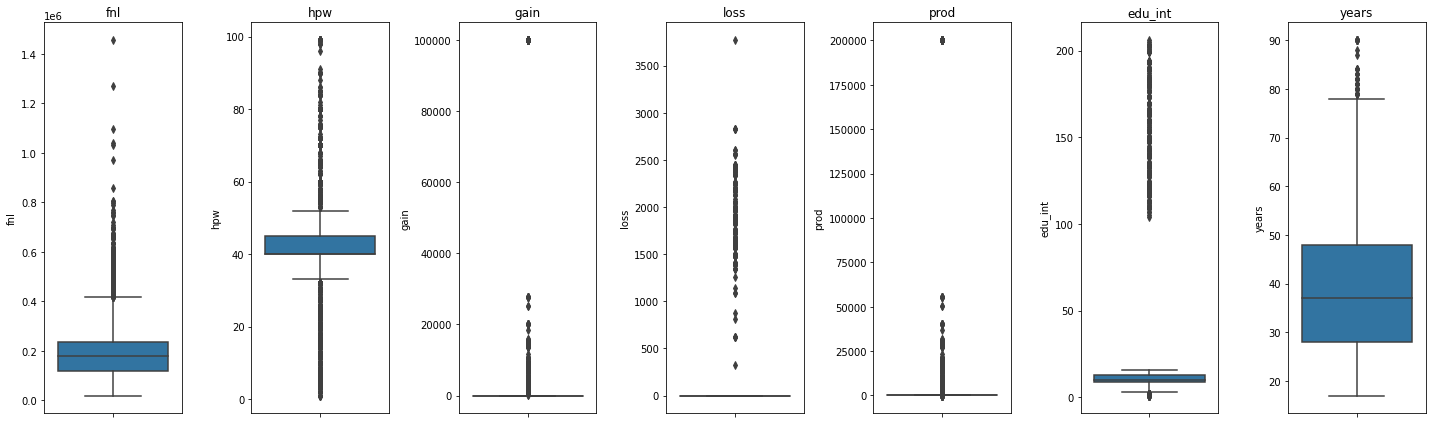

In [123]:
# Create subplots for boxplots
def print_numerical_features_boxplots(df, features):
    fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(20, 6))

    for i, numerical_feature in enumerate(features):
        sns.boxplot(data=df, y=numerical_feature, ax=axes[i])
        axes[i].set_title(numerical_feature)

    plt.tight_layout()
    plt.show()
    
print_numerical_features_boxplots(salary_df, features["numerical"]["attributes"] + features["ordinal"]["attributes"])

### Categorical Features - including binary features

In [124]:
categorical_combined_stats_df = pd.DataFrame()

for categorical_feature in features["categorical"]["attributes"] + features["binary"]["attributes"]:
    non_missing_count = salary_df[categorical_feature].notnull().sum()
    unique_count = salary_df[categorical_feature].nunique()
    
    # Combine statistics into a dictionary
    stats_dict = {
        'num_examples': non_missing_count,
        'num_unique': unique_count
    }
    
    # Convert to DataFrame for a table-like display
    stats_df = pd.DataFrame(stats_dict, index=[categorical_feature])
    categorical_combined_stats_df = pd.concat([categorical_combined_stats_df, stats_df])

display(categorical_combined_stats_df.style.format({
    'num_examples': '{:,.0f}',
    'num_unique': '{:,.0f}'
}).set_properties(**{'text-align': 'center'}).set_table_styles([{
    'selector': 'th',
    'props': [('font-size', '12pt')]
}, {
    'selector': 'td',
    'props': [('font-size', '12pt')]
}]))

,num_examples,num_unique
relation,"9,999",6
country,"9,999",41
job,"9,999",14
work_type,"9,999",9
partner,"9,999",7
edu,"9,999",16
race,"9,999",5
gender,"9,199",2
gtype,"9,999",2
money,"9,999",2


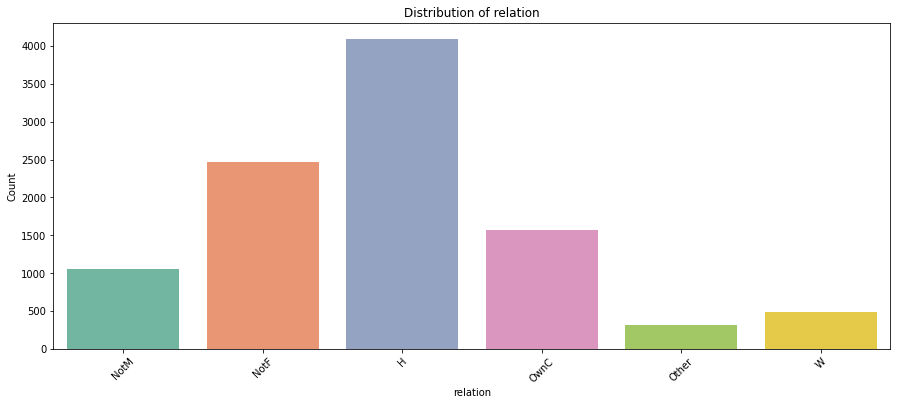

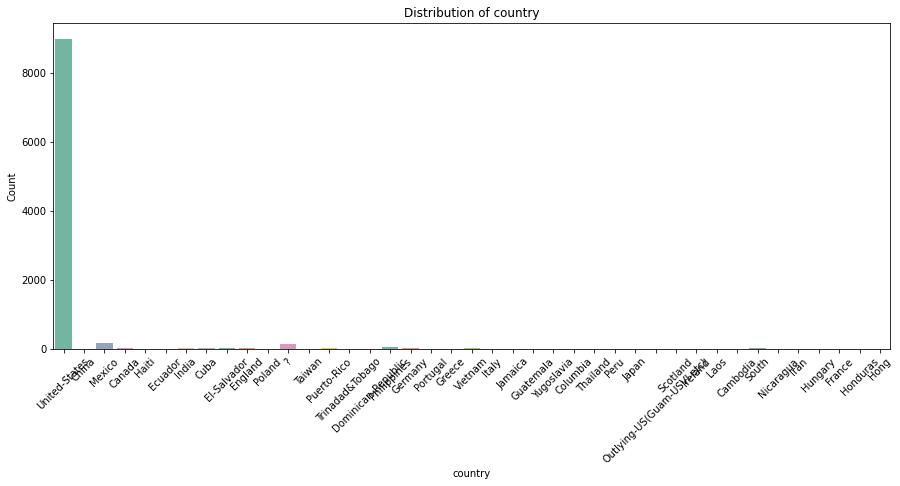

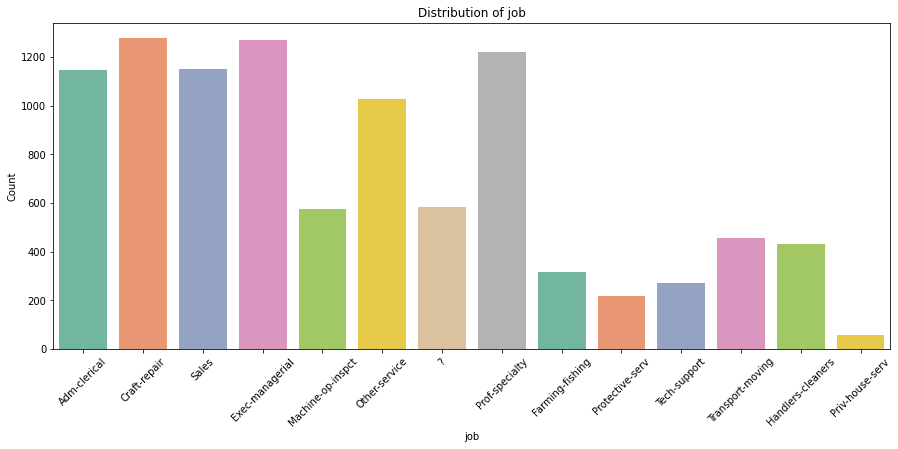

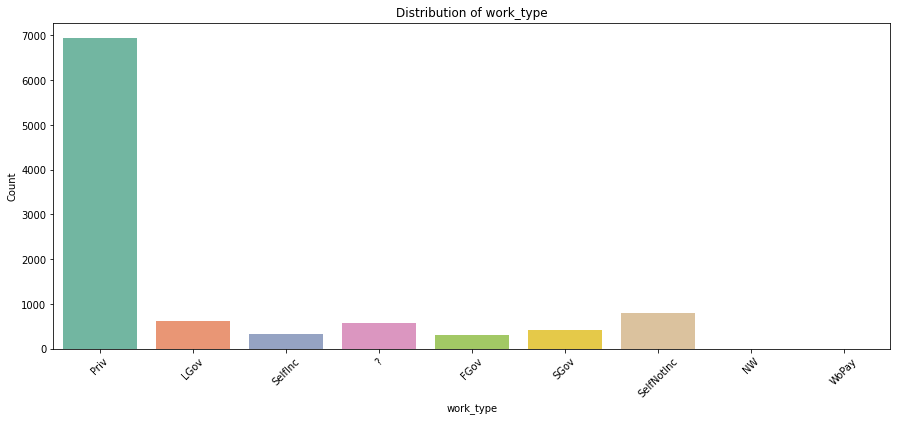

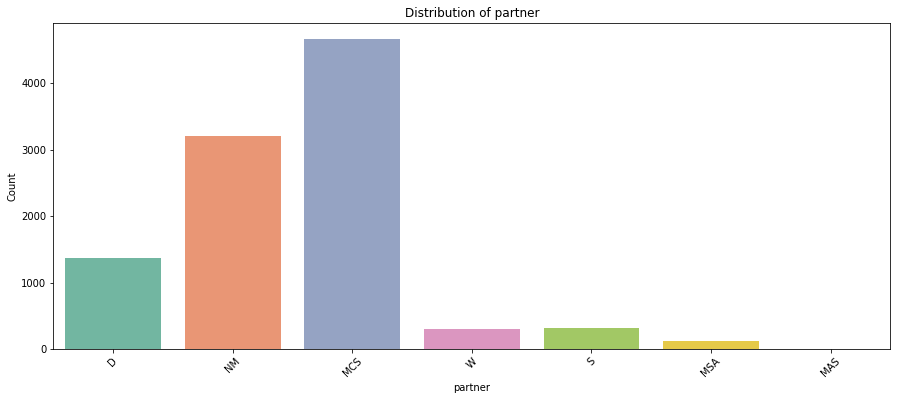

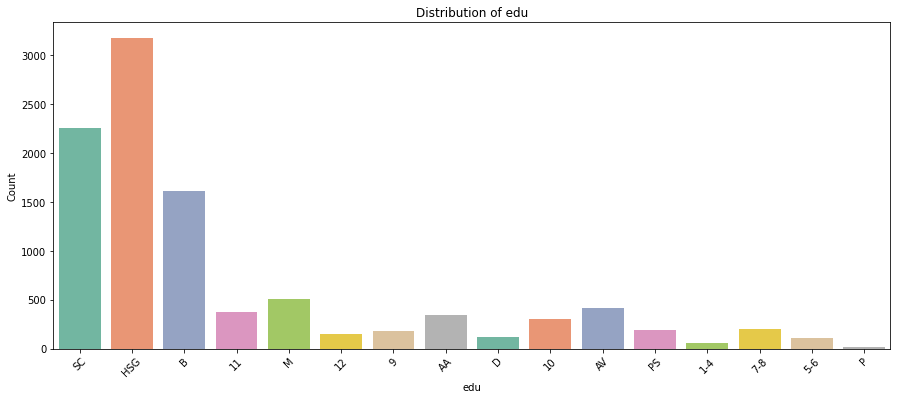

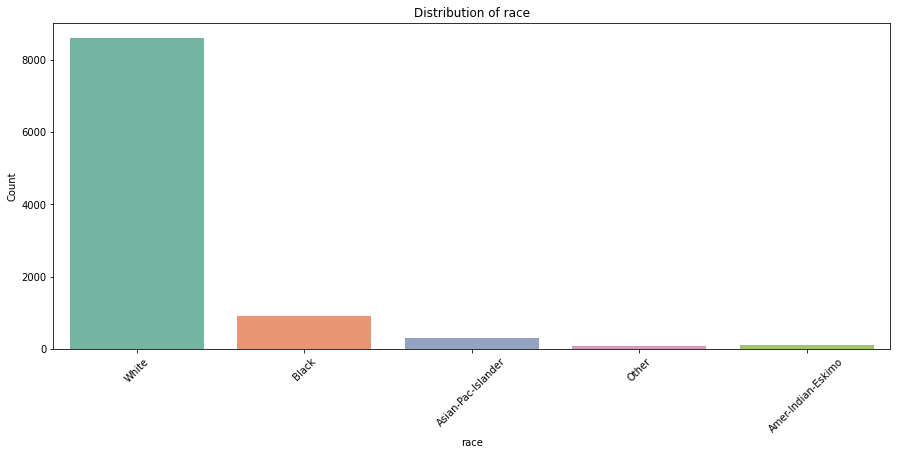

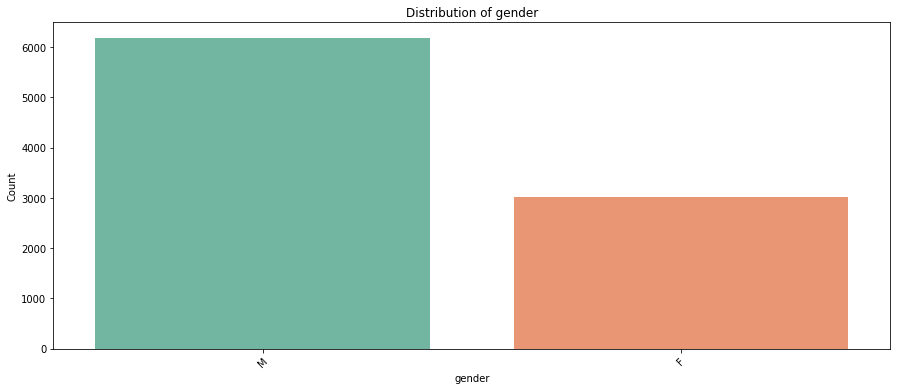

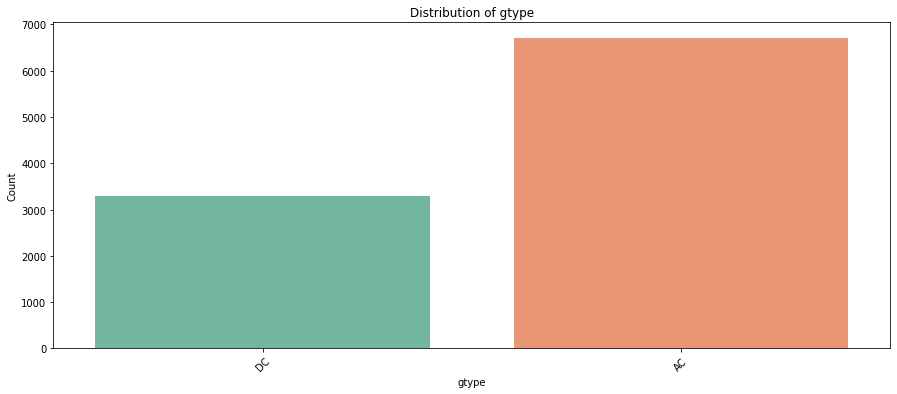

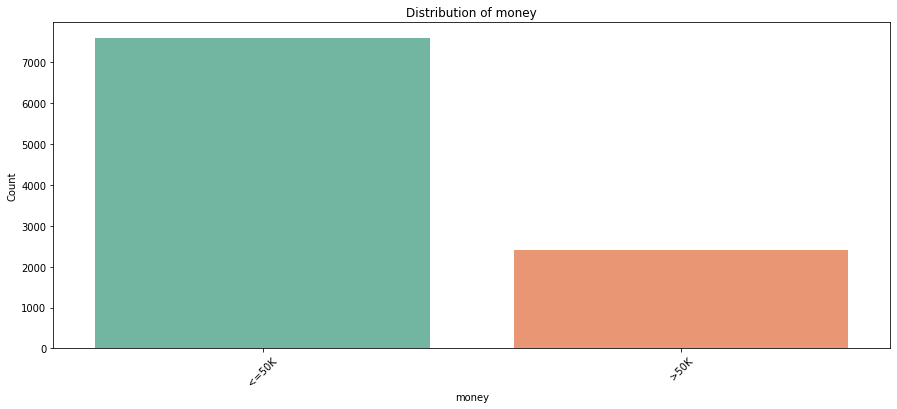

In [125]:
for feature in features["categorical"]["attributes"] + features["binary"]["attributes"]:
    plt.figure(figsize=(15, 6))
    sns.countplot(data=salary_df, x=feature, palette='Set2')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

### Correlation Analysis

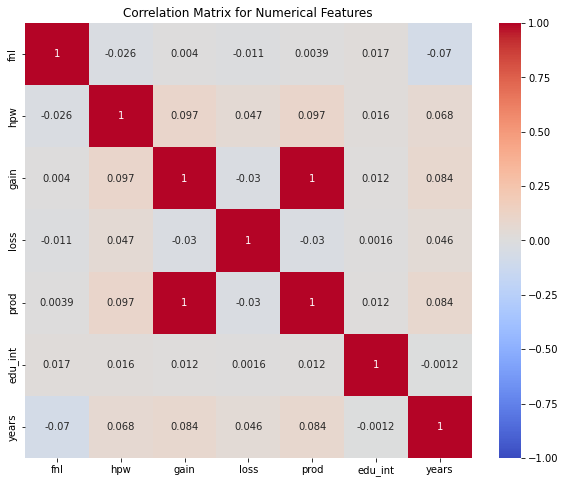

In [126]:
# Numerical features - including ordinal features
corr_matrix = salary_df[features["numerical"]["attributes"] + features["ordinal"]["attributes"]].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Numerical Features')
plt.show()

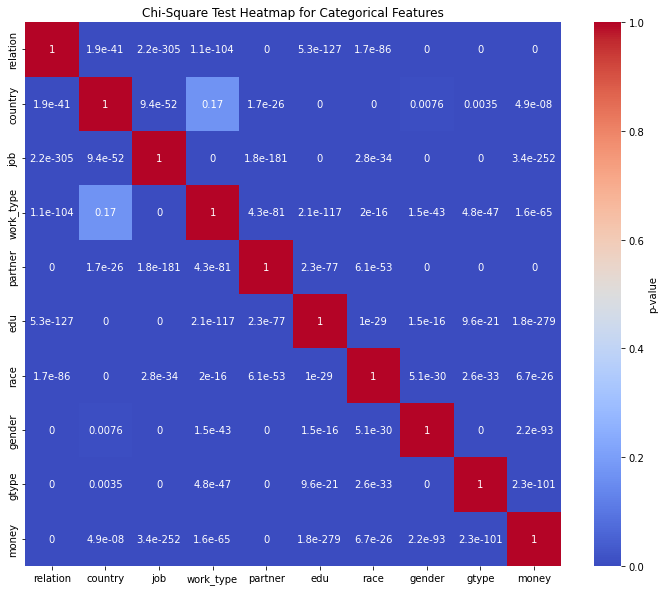

In [127]:
cat_attributes = features["categorical"]["attributes"] + features["binary"]["attributes"]

# chi_square lambda function to be used for finding correlations between categorical features
chi_square = lambda df, f1, f2: chi2_contingency(pd.crosstab(df[f1], df[f2]))[1]
categorical_corr = pd.DataFrame(np.ones((len(cat_attributes), len(cat_attributes))),
                                index=cat_attributes, columns=cat_attributes)

for f1, f2 in list(filter(lambda f: f[0] != f[1], list(itertools.product(cat_attributes, repeat=2)))):
    categorical_corr.at[f1, f2] = categorical_corr.at[f2, f1] = chi_square(salary_df, f1, f2)

plt.figure(figsize=(12, 10))
sns.heatmap(categorical_corr, annot=True, cmap='coolwarm', vmin=0, vmax=1, cbar_kws={'label': 'p-value'})
plt.title('Chi-Square Test Heatmap for Categorical Features')
plt.show()


## 3.2 Data preprocessing

#### 3.2.1 Missing values

There are just two features with missing values - hpw and gender.

In [128]:
simple_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Fill the missing values from hpw with mean value
salary_df['hpw'] = simple_imputer.fit_transform(salary_df['hpw'].values.reshape(-1, 1))
salary_train_df['hpw'] = simple_imputer.transform(salary_train_df['hpw'].values.reshape(-1, 1))
salary_test_df['hpw'] = simple_imputer.transform(salary_test_df['hpw'].values.reshape(-1, 1))

In [129]:
# For gender, it is a wild guess to fill the missing values with the most common value, so we will drop the rows
salary_df = salary_df.dropna(subset=["gender"])
salary_train_df = salary_train_df.dropna(subset=["gender"])
salary_test_df = salary_test_df.dropna(subset=["gender"])

#### 3.2.2 Extreme values - Outliers

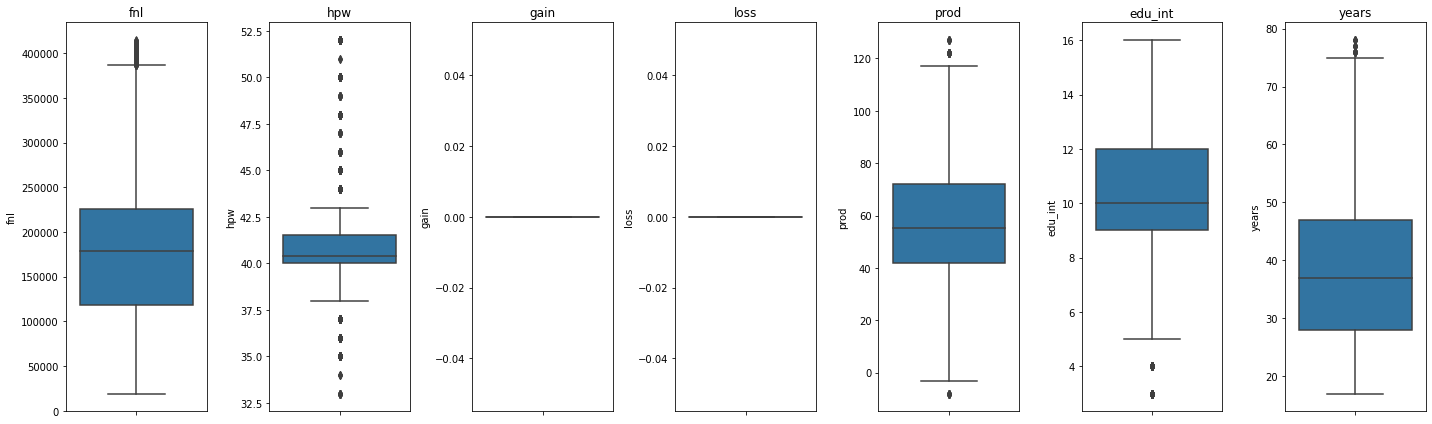

In [130]:
def outliers(df, feature):
    Q_low = df[feature].quantile(0.25)
    Q_high = df[feature].quantile(0.75)
    IQR = Q_high - Q_low
    upper_limit = Q_high + 1.5 * IQR
    lower_limit = Q_low - 1.5 * IQR

    # Use SimpleImputer to fill the outliers with the mean value
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    
    # Assign np.nan to the outliers
    df.loc[(df[feature] < lower_limit) | (df[feature] > upper_limit), feature] = np.nan
    
    # Fill the outliers with the mean value
    df[feature] = imputer.fit_transform(df[feature].values.reshape(-1, 1))
    
    return df

for feature in features["numerical"]["attributes"] + features["ordinal"]["attributes"]:
    salary_df = outliers(salary_df, feature)
    salary_train_df = outliers(salary_train_df, feature)
    salary_test_df = outliers(salary_test_df, feature)
    
print_numerical_features_boxplots(salary_df, features["numerical"]["attributes"] + features["ordinal"]["attributes"])

#### 3.2.3 Removing the redundant features - strongly correlated features

In [131]:
removed_numerical_categories = ["gain"]
removed_categorical_categories = ["work_type", "partner", "edu", "race", "gtype", "country"]

# For the numerical features, I will remove the "gain" feature, as it is strongly correlated to "prod"
# and does not bring any additional information
salary_df = salary_df.drop(columns = removed_numerical_categories)
salary_train_df = salary_train_df.drop(columns = removed_numerical_categories)
salary_test_df = salary_test_df.drop(columns = removed_numerical_categories)

# For the categorical features, I am going to remove the most obvious ones (where p-value is 0)
salary_df = salary_df.drop(columns = removed_categorical_categories)
salary_train_df = salary_train_df.drop(columns = removed_categorical_categories)
salary_test_df = salary_test_df.drop(columns = removed_categorical_categories)

# Also remove these from features
features["categorical"]["attributes"] = [feature for feature in features["categorical"]["attributes"] if feature not in removed_categorical_categories]
features["categorical"]["size"] = len(features["categorical"]["attributes"])

features["numerical"]["attributes"] = [feature for feature in features["numerical"]["attributes"] if feature not in removed_numerical_categories]
features["numerical"]["size"] = len(features["numerical"]["attributes"])
        
features["binary"]["attributes"] = [feature for feature in features["binary"]["attributes"] if feature not in removed_categorical_categories]
features["binary"]["size"] = len(features["binary"]["attributes"])

#### 3.2.4 Standardization for numerical features

RobustScaler may not be the best choice as the outliers have been removed.
MinMaxScaler may not be the best choice as the data is not normally distributed, and a normalization is required.
StandardScaler is the best choice for this dataset, suitable for the logistic regression and for features with different scales.

In [132]:
standard_scaler = StandardScaler()

for feature in features["numerical"]["attributes"] + features["ordinal"]["attributes"]:
    salary_df[feature] = standard_scaler.fit_transform(salary_df[feature].values.reshape(-1, 1))
    salary_train_df[feature] = standard_scaler.transform(salary_train_df[feature].values.reshape(-1, 1))
    salary_test_df[feature] = standard_scaler.transform(salary_test_df[feature].values.reshape(-1, 1))

# min_max_scaler = MinMaxScaler()

# for feature in features["numerical"]["attributes"] + features["ordinal"]["attributes"]:
#     salary_df[feature] = normalize(salary_df[feature].values.reshape(-1, 1))
#     salary_train_df[feature] = normalize(salary_train_df[feature].values.reshape(-1, 1))
#     salary_test_df[feature] = normalize(salary_test_df[feature].values.reshape(-1, 1))

#     salary_df[feature] = min_max_scaler.fit_transform(salary_df[feature].values.reshape(-1, 1))
#     salary_train_df[feature] = min_max_scaler.transform(salary_train_df[feature].values.reshape(-1, 1))
#     salary_test_df[feature] = min_max_scaler.transform(salary_test_df[feature].values.reshape(-1, 1))


#### 3.2.5 Encoding categorical features

In [133]:
# For binary features, I will use the LabelEncoder - this includes the target feature
label_encoder = LabelEncoder()
for feature in features["binary"]["attributes"]:
    salary_df[feature] = label_encoder.fit_transform(salary_df[feature])
    salary_train_df[feature] = label_encoder.fit_transform(salary_train_df[feature])
    salary_test_df[feature] = label_encoder.fit_transform(salary_test_df[feature])
    
# For the categorical features with less than 20 unique values, I will use the OneHotEncoder
one_hot_encoder = OneHotEncoder(drop="first", sparse_output=False)
for feature in features["categorical"]["attributes"]:
    if feature in salary_df:
        encoded = one_hot_encoder.fit_transform(salary_df[feature].values.reshape(-1, 1))
        column_names = [f"{feature}_{category}" for category in one_hot_encoder.categories_[0][1:]]
        encoded_df = pd.DataFrame(encoded, columns=column_names)
        salary_df = pd.concat([salary_df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)
        salary_df = salary_df.drop(columns=[feature])

        encoded_train = one_hot_encoder.fit_transform(salary_train_df[feature].values.reshape(-1, 1))
        column_names = [f"{feature}_{category}" for category in one_hot_encoder.categories_[0][1:]]
        encoded_train_df = pd.DataFrame(encoded_train, columns=column_names)
        salary_train_df = pd.concat([salary_train_df.reset_index(drop=True), encoded_train_df.reset_index(drop=True)], axis=1)
        salary_train_df = salary_train_df.drop(columns=[feature])
        
        encoded_test = one_hot_encoder.fit_transform(salary_test_df[feature].values.reshape(-1, 1))
        column_names = [f"{feature}_{category}" for category in one_hot_encoder.categories_[0][1:]]
        encoded_test_df = pd.DataFrame(encoded_test, columns=column_names)
        salary_test_df = pd.concat([salary_test_df.reset_index(drop=True), encoded_test_df.reset_index(drop=True)], axis=1)
        salary_test_df = salary_test_df.drop(columns=[feature])
        
salary_df

,fnl,hpw,edu_int,years,loss,gender,prod,money,relation_NotF,relation_NotM,...,job_Farming-fishing,job_Handlers-cleaners,job_Machine-op-inspct,job_Other-service,job_Priv-house-serv,job_Prof-specialty,job_Protective-serv,job_Sales,job_Tech-support,job_Transport-moving
0,-3.358385e-01,-0.454896,-0.446800,1.762997,0.0,1,1.353672,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.767175e-02,0.000000,1.185176,0.267679,0.0,1,0.928135,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-3.390974e-01,0.000000,-0.038806,0.192913,0.0,1,2.204746,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-3.024205e-02,-0.454896,-0.446800,-1.003341,0.0,1,0.077061,0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.387426e-16,-0.454896,-1.262788,1.314401,0.0,0,0.289830,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9194,8.454284e-02,-0.454896,-0.446800,1.463933,0.0,1,-1.412318,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9195,2.562847e+00,1.054643,-1.262788,-0.330448,0.0,1,0.077061,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9196,-1.083127e+00,0.000000,-1.262788,1.987294,0.0,0,1.140904,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9197,-1.834118e+00,1.054643,-0.446800,-0.704277,0.0,1,0.289830,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Logistic Regression

In [134]:

class LogisticRegression:

    # Logistic sigmoid
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Negative log-likelihood
    def nll(Y, T):
        return -np.mean(T * np.log(Y) + (1 - T) * np.log(1 - Y))

    # Classification accuracy
    def accuracy(Y, T):
        return np.mean((Y >= 0.5) == T)
    
    # Predict logistic that returns the predictions y for the given input X
    def predict(X, w):
        return LogisticRegression.sigmoid(np.dot(X, w))

    def train_and_eval(X_train, T_train, X_test, T_test, N, D, lr=.01, epochs_no=100):
        w = np.random.randn(D)
        
        train_acc, test_acc = [], []
        train_nll, test_nll = [], []

        predict_logistic = LogisticRegression.predict
        nll = LogisticRegression.nll
        accuracy = LogisticRegression.accuracy

        for epoch in range(epochs_no):
            Y_train = predict_logistic(X_train, w)
            Y_test = predict_logistic(X_test, w)
            
            train_nll.append(nll(Y_train, T_train))
            train_acc.append(accuracy(Y_train, T_train))
            
            test_nll.append(nll(Y_test, T_test))
            test_acc.append(accuracy(Y_test, T_test))
            
            w -= lr * np.dot(X_train.T, Y_train - T_train) / N
        
        return w, train_nll, test_nll, train_acc, test_acc
    
    def visualize_confusion_matrix(T, Y):
        """
            True negative = (0, 0)
            False negative = (1, 0)
            True positive = (1, 1)
            False positive = (0, 1)            
        """

        idx_tp = np.logical_and(T >= .5, Y >= .5) # True positives
        idx_fp = np.logical_and(T < .5, Y >= .5) # False positives
        idx_fn = np.logical_and(T >= .5, Y < .5) # False negatives
        idx_tn = np.logical_and(T < .5, Y < .5) # True negatives
        
        cm = np.array([[np.sum(idx_tn), np.sum(idx_fp)], [np.sum(idx_fn), np.sum(idx_tp)]])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
    
    def visualize_dataset(X, T, Y=None, w=None, other_w=None):
        m = ["x", "o"]  # Indicates true class
        col = ["red", "blue"]  # Indicates prediction
        fig = plt.figure(); plt.axis('equal')
        if Y is not None:
            idx_tp = np.logical_and(T >= .5, Y >= .5) # True positives
            idx_fp = np.logical_and(T < .5, Y >= .5) # False positives
            idx_fn = np.logical_and(T >= .5, Y < .5) # False negatives
            idx_tn = np.logical_and(T < .5, Y < .5) # True negatives

            plt.scatter(X[idx_tp,0], X[idx_tp,1], marker=m[0], c="red", label="TP")
            plt.scatter(X[idx_fp,0], X[idx_fp,1], marker=m[1], c="red", label="FP")
            plt.scatter(X[idx_fn,0], X[idx_fn,1], marker=m[0], c="blue", label="FN")
            plt.scatter(X[idx_tn,0], X[idx_tn,1], marker=m[1], c="blue", label="TN")

        else:
            idx_pos, idx_neg = (T > .5), (T < .5)
            plt.scatter(X[idx_pos,0], X[idx_pos,1], marker=m[0], color="blue", label="Pos")
            plt.scatter(X[idx_neg,0], X[idx_neg,1], marker=m[1], color="blue", label="Neg")
        
        if w is not None:
            __x = np.linspace(0, 1, 2)
            __y = -w[0] / w[1] * __x - w[2] / w[1]
            plt.plot(__x, __y, color="black")

        if other_w is not None:
            __x = np.linspace(0, 1, 2)
            __y = -other_w[0] / other_w[1] * __x - other_w[2] / other_w[1]
            plt.plot(__x, __y, color="orange")

        plt.xlabel("x"); plt.ylabel("y")
        plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
        plt.show()


# Apply the algorithms on Salary Classification dataset

In [135]:
# Add a column of ones to the input data
salary_df = pd.concat([pd.Series(1, index=salary_df.index, name='00'), salary_df], axis=1)
salary_train_df = pd.concat([pd.Series(1, index=salary_train_df.index, name='00'), salary_train_df], axis=1)
salary_test_df = pd.concat([pd.Series(1, index=salary_test_df.index, name='00'), salary_test_df], axis=1)

In [136]:
# Separate the target feature from the rest of the dataset
X = salary_df.drop(columns=['money'])
T = salary_df['money']

X_train = salary_train_df.drop(columns=['money'])
T_train = salary_train_df['money']

X_test = salary_test_df.drop(columns=['money'])
T_test = salary_test_df['money']

salary_df

,00,fnl,hpw,edu_int,years,loss,gender,prod,money,relation_NotF,...,job_Farming-fishing,job_Handlers-cleaners,job_Machine-op-inspct,job_Other-service,job_Priv-house-serv,job_Prof-specialty,job_Protective-serv,job_Sales,job_Tech-support,job_Transport-moving
0,1,-3.358385e-01,-0.454896,-0.446800,1.762997,0.0,1,1.353672,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,9.767175e-02,0.000000,1.185176,0.267679,0.0,1,0.928135,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,-3.390974e-01,0.000000,-0.038806,0.192913,0.0,1,2.204746,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,-3.024205e-02,-0.454896,-0.446800,-1.003341,0.0,1,0.077061,0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,3.387426e-16,-0.454896,-1.262788,1.314401,0.0,0,0.289830,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9194,1,8.454284e-02,-0.454896,-0.446800,1.463933,0.0,1,-1.412318,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9195,1,2.562847e+00,1.054643,-1.262788,-0.330448,0.0,1,0.077061,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9196,1,-1.083127e+00,0.000000,-1.262788,1.987294,0.0,0,1.140904,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9197,1,-1.834118e+00,1.054643,-0.446800,-0.704277,0.0,1,0.289830,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Final accuracy - train: 0.8180302819836088, test: 0.832


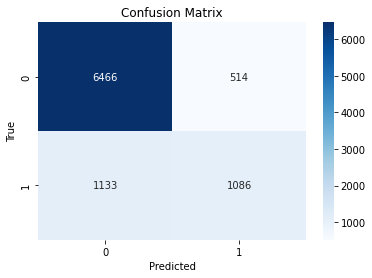

In [145]:
N_EPOCHS = 1500

(N, D) = X.shape

w, train_nll, test_nll, train_acc, test_acc = LogisticRegression.train_and_eval(X_train, T_train, X_test, T_test, N, D, lr=0.1, epochs_no=N_EPOCHS)

Y = LogisticRegression.predict(X, w)

print(f"Final accuracy - train: {train_acc[-1]}, test: {test_acc[-1]}")
LogisticRegression.visualize_confusion_matrix(T.values, Y)


C:\Users\Stefan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Scikit-learn final accuracy - train: 0.8309487428809557, test: 0.831


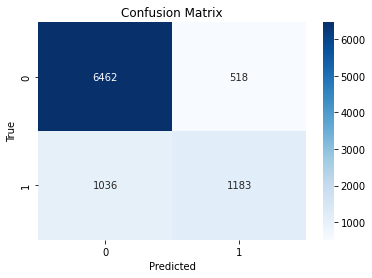

In [138]:
clf = SKLogisticRegression(random_state=0).fit(X_train, T_train)
Y = clf.predict(X)

print(f"Scikit-learn final accuracy - train: {clf.score(X_train, T_train)}, test: {clf.score(X_test, T_test)}")
LogisticRegression.visualize_confusion_matrix(T.values, Y)